# Biggest todos

- Solve the problem of the missing data
    - Partial solution: Masked loss function

# Imports

In [1]:
import scipy
import datetime
import re
import wandb
import os
import sklearn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from glob import glob
from missingno import matrix
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.data import Dataset
from sklearn.linear_model import *
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

os.environ["WANDB_SILENT"] = "True"
wandb.login()

True

# URLS

In [2]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

# Load data

In [3]:
# Rain gauge metadata
df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')

# Rain gauges - Review processing of this data before proceeding 
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
gauges_raw_hour = gauges_raw.resample('1h').sum().rename(lambda x : str(x) + '_R_raw',axis=1)

# Processed rain gauge data
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean = gauges_clean.rename(lambda x : str(x) + '_R_manual',axis=1)

# All rain gauge data 
gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)
first_non_0 = gauges.fillna(0).apply(lambda x : np.argwhere(x.values != 0)[0])
gauges = gauges.apply(lambda x : x.iloc[first_non_0.loc[:,x.name][0]:])  

# Remove rediculous outliers (53 is larges in manual dataset)
gauges[gauges.values > 55]= np.nan

# other variables
df_temperature =  pd.read_pickle('../Rainfall - runoff/temperature_data.pkl')
df_temperature = df_temperature.rename(lambda x : str(x) + '_T',axis=1)

# Drainage flow data
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
df_target = df_target.drop(['MOS-HOL','KOP-HAB'],axis=1)


In [4]:
# extra rain-gauges for writing purposes
grindavik = pd.read_csv('../../Data/Fyrir sverri folderinn/Grindavik_1490_hragogn.csv',sep='\t')
fiflholt = pd.read_csv('../../Data/Fyrir sverri folderinn/Fiflholt_1868_hragogn.csv',sep='\t')
hellisskard = pd.read_csv('../../Data/Fyrir sverri folderinn/Hellisskard_1490_hragogn.csv',sep='\t')
hvanneyri = pd.read_csv('../../Data/Fyrir sverri folderinn/hvanneyri_1779_hragogn.csv',sep='\t')

In [6]:
DIR_rain_gauges

['C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1473_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1474_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1475_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1478_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1481_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1482_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1485_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1578_cleaned']

In [7]:
# gauges.to_pickle('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/rain_gauges_combined.pkl')

In [5]:
# grindavik,fiflholt

In [6]:
# for g in gauges_raw:
#     try:
#         stod = df_sensors.loc[df_sensors.loc[:,'STOD'] == int(g)]
#         N = stod.loc[:,'BREIDD'].iloc[0]
#         W = stod.loc[:,'LENGD'].iloc[0]
#         nafn = stod.loc[:,'NAFN'].iloc[0]
#     except:
#         W=N=nafn='?'
#     print(g,'{', gauges_raw.loc[:,g].dropna().index[0].date(),'} {',N,',',W,'} {',nafn,'}')
#     print()

# Merge data for variable selection

In [7]:
rolling_size = 24

Xg = gauges.copy()
Xt = df_temperature.copy()
Xtr = Xt.rolling(rolling_size,1).mean().rename(lambda x : str(x) + f'_rolling{rolling_size}',axis=1)

X = pd.concat([Xg,Xtr],axis=1)
Y = df_target.copy()

X_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
Y_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
X = X.loc[:datetime.datetime(2020,1,1,0,0,0)]
Y = Y.loc[:datetime.datetime(2020,1,1,0,0,0)]

# Visualize missing data in dataset

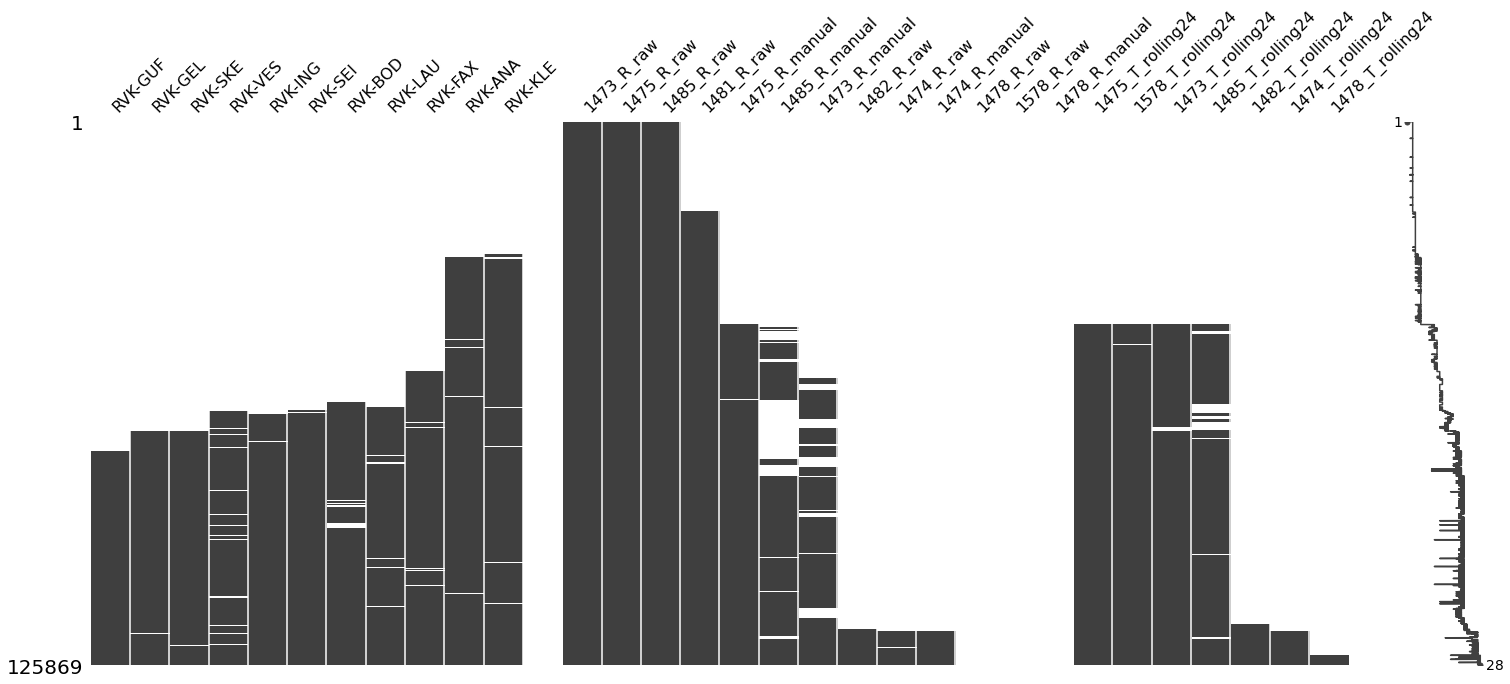

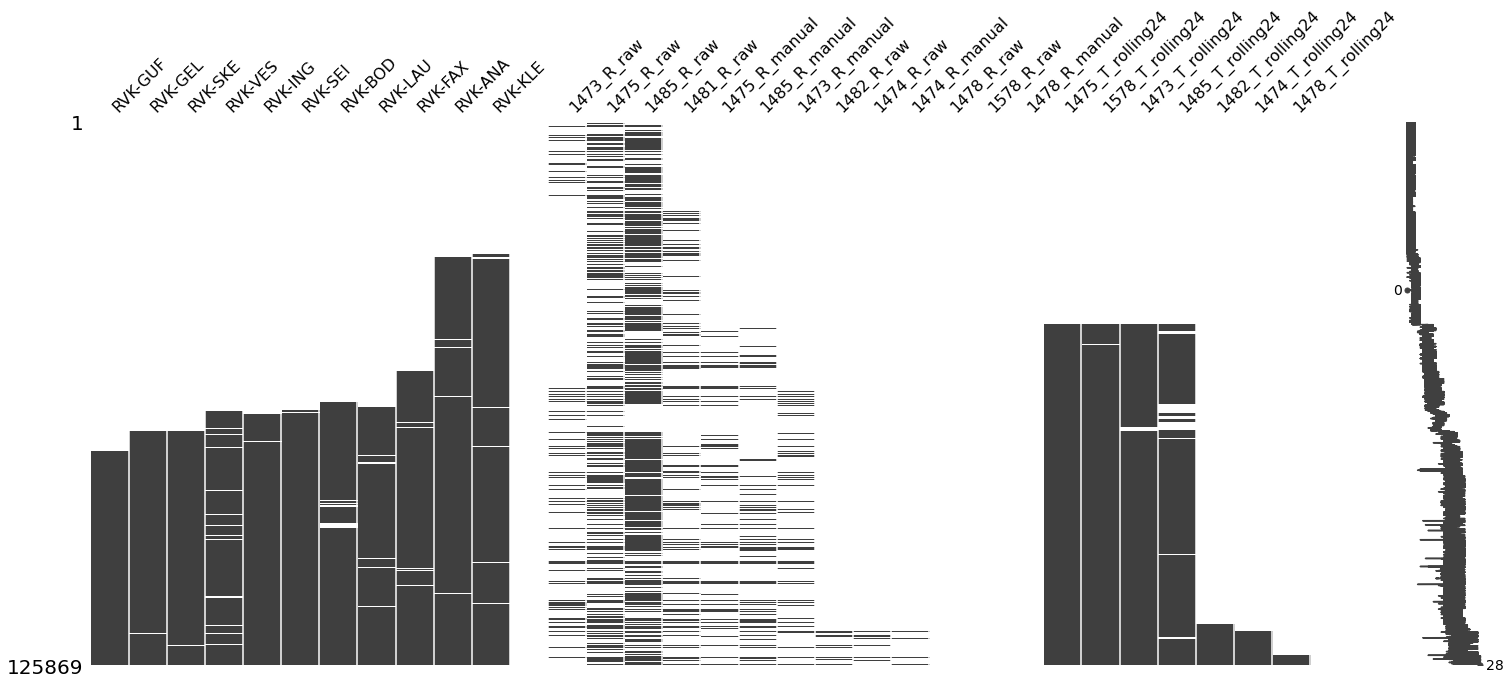

In [8]:
count_sort_Xg = (~Xg.isna()).sum().sort_values().index[::-1]
count_sort_Xtr = (~Xtr.isna()).sum().sort_values().index[::-1] 
count_sort_X = np.concatenate([count_sort_Xg,count_sort_Xtr])
count_sort_Y = (~Y.isna()).sum().sort_values().index

Y = Y.loc[:,count_sort_Y]
X = X.loc[:,count_sort_X]

matrix(pd.concat([Y,
                  pd.Series(name='',dtype=float),
                  X],axis=1))
plt.show()

matrix(pd.concat([Y,
                  pd.Series(name='',dtype=float),
                  X,
                  pd.Series(name='',dtype=float),],axis=1).replace({0:np.nan}))
plt.show()

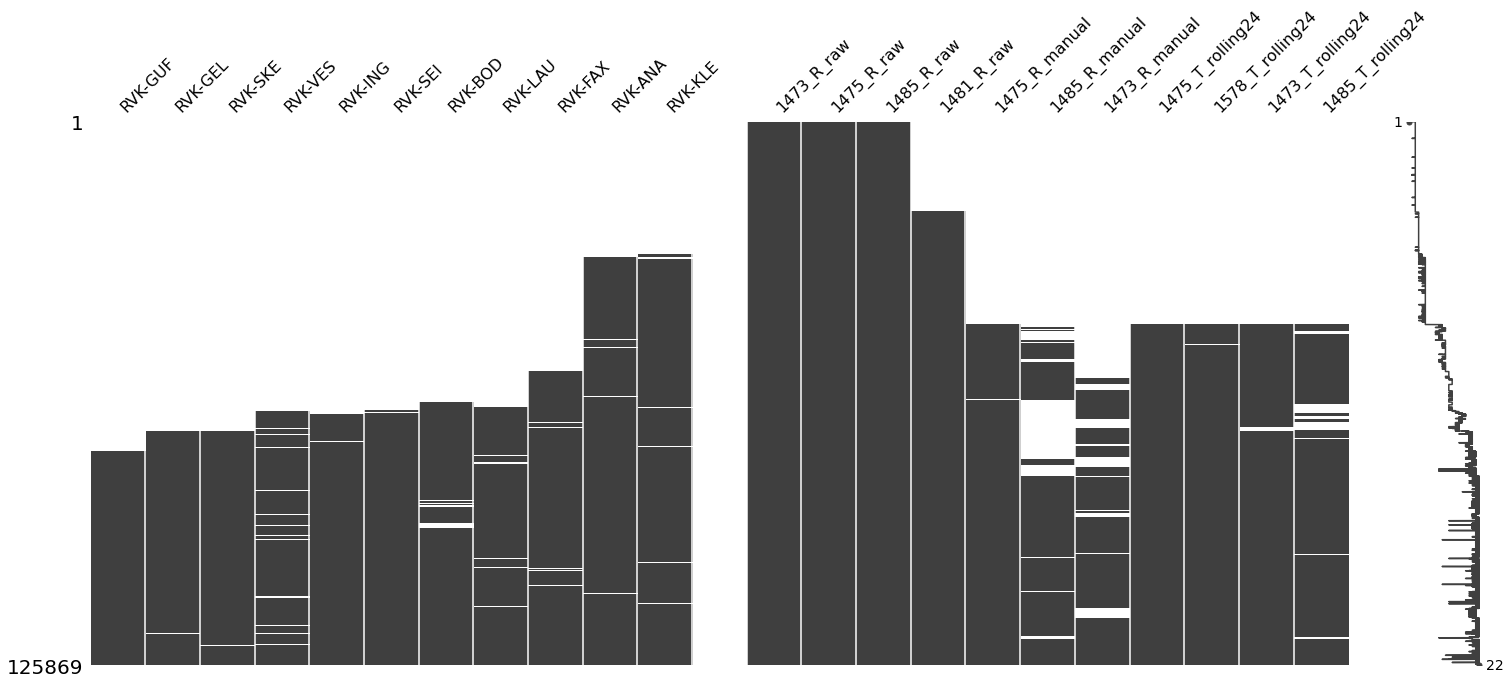

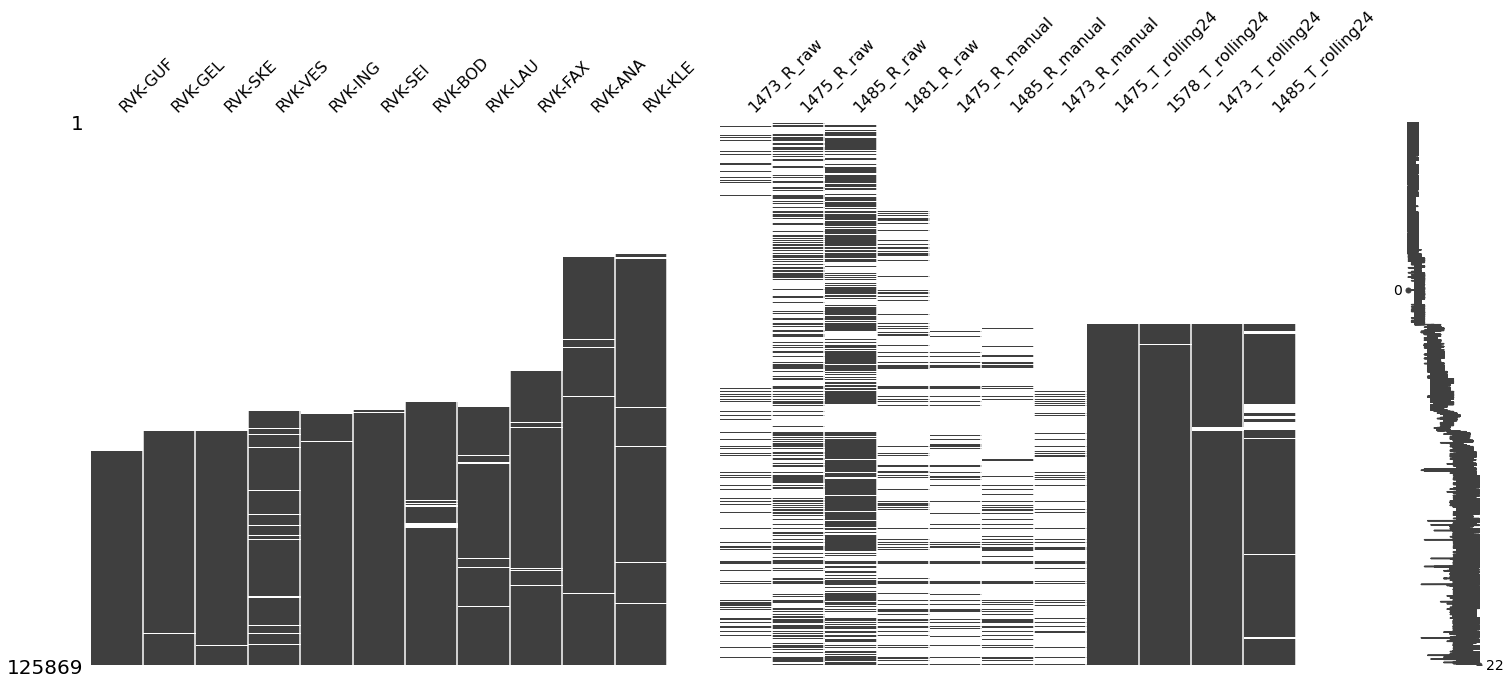

In [9]:
# Remove some variables that have too little data
excluded_variables = ['1482_R_raw','1474_R_raw','1474_R_manual','1478_R_raw','1578_R_raw','1478_R_manual',
                      '1474_T_rolling24','1482_T_rolling24', '1478_T_rolling24',]
X = X.drop(excluded_variables,axis=1)
X_test = X_test.drop(excluded_variables,axis=1)


matrix(pd.concat([Y,
                  pd.Series(name='',dtype=float),
                  X],axis=1))
plt.show()

matrix(pd.concat([Y,
                  pd.Series(name='',dtype=float),
                  X,
                  pd.Series(name='',dtype=float),],axis=1).replace({0:np.nan}))
plt.show()

In [10]:
lag_values = range(-10,10)
corr_dict = {}
for d in X.columns:
    corr_dict_tmp = {}
    for g in Y.columns:
        a = Y.loc[:,g]
        b = X.loc[:,d]
        corr_dict_tmp[g] = [a.shift(l).corr(b) for l in lag_values]
    corr_dict[d] = corr_dict_tmp


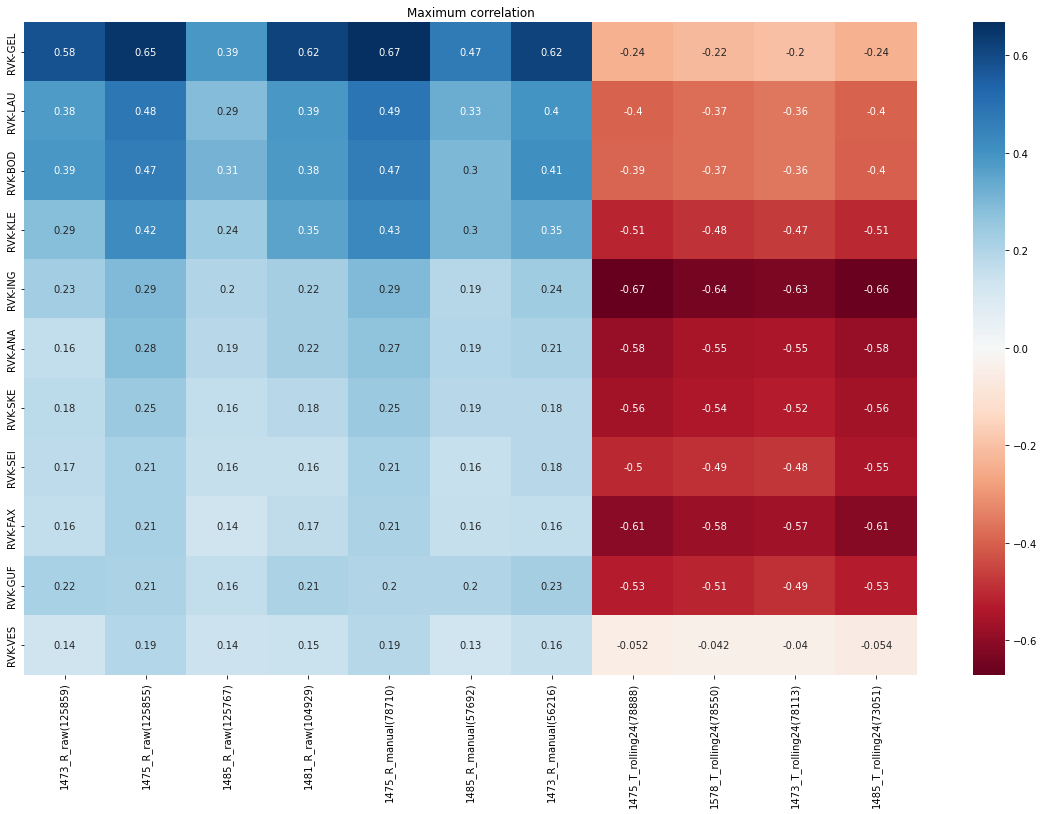

In [11]:
df_corr_all = pd.DataFrame(corr_dict)
corr_argsort = df_corr_all.applymap(np.max).loc[:,'1475_R_raw'].sort_values().index[::-1]

# Reorder using same as above
df_corr_all = df_corr_all.loc[corr_argsort,]

plt.figure(figsize=(20,12))
# sns.heatmap(df_corr_all.applymap(np.max),annot=True, cmap='RdBu')
sns.heatmap(df_corr_all.rename(lambda x : str(x) + '(' + str(X.loc[:,x].dropna().shape[0]) + ')',axis=1).applymap(np.max),
            annot=True, cmap='RdBu')

plt.title('Maximum correlation')
plt.show()

# Picking input data to focus analysis on

Drainage sensors:
- RVK-GEL has by far the best correlation with rain-gauges of all the sensors. 
- There after, it's RVK-LAU, which has a 0.54 correlation with it's best rain-gauge but in turn has a 0.41 correlation with th best temperature and so is a good candidate for predictability in general.


Rain-gauges: 
- Of all the rain-gauges, the one at station 1485 has the most non-zero data but also the weakest correlation with the drainage flow
- There after is the one at 1475, which has only a small gap in 2013 and a 0.56 correlation with our target
- 1481 has lots of data


Pair: The combinations of data that stick most out in terms of data availability and correlation appear to be:
- RVK-GEL, 1475_R_manual, 1475_T_rolling24
- RVK-LAU, 1475_R_manual, 1475_T_rolling24

In [12]:
drainage_names = ['RVK-GEL','RVK-BOD']
temperature_name = '1475_T_rolling24'
gauge_name = '1475_R_manual'


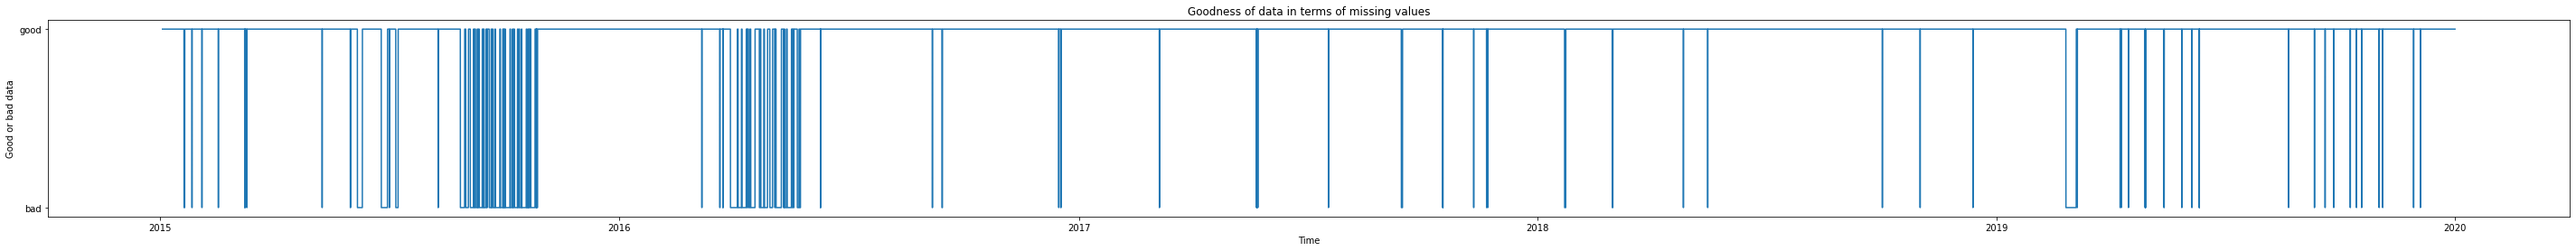

In [13]:
def create_dataset(series_list,lag):
    # Start by joining all data and recomputing with nan-values so timing isn't affected
    df_combined = pd.concat(series_list,axis=1)
    
    df_combined = df_combined.resample('1h').mean()
    combined_index = df_combined.index
    output_list = []
    for col in df_combined:
        series_tmp = df_combined.loc[:,col].values.ravel()
        output_tmp = sliding_window_view(series_tmp, lag).squeeze()
        output_list.append(output_tmp)
        
    date_sequences = sliding_window_view(combined_index, lag).squeeze()
    
    return output_list,date_sequences

# Start and end date for training data because it has to match available radar data
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)


lag = 48
Y_all = Y.loc[d_start:d_end,drainage_names]#copy()#.interpolate(method='linear',limit = 1)

threshold_dict = {'RVK-GEL':[0,100,200,300,400,600,800,1000],
              'RVK-BOD':[0,25,50,75,100,125,150,200]}
thresholds = np.array(list(threshold_dict.values()))

daily_sum_sorted = Y_all.resample('1d').sum().sum(axis=1).sort_values()[::-1]
top_1000_drainage_days = daily_sum_sorted.index[:1000]


Xt_all = X.loc[d_start:d_end,temperature_name].copy()
Xg_all = X.loc[d_start:d_end,gauge_name].copy()



[Xt_all_seq_dirty,Xg_all_seq_dirty,*Y_all_seq_dirty],dates_all_seq_dirty = create_dataset([Xt_all,Xg_all,Y_all],lag)

# Take all but last value away from data where lagged value isn't necessary
if type(Y_all_seq_dirty) == list:
    Y_all_seq_dirty = np.concatenate([i[:,:,np.newaxis] for i in Y_all_seq_dirty],axis=2)

Y_all_seq_dirty = Y_all_seq_dirty[:,-1]
Xt_all_seq_dirty = Xt_all_seq_dirty

# Drop rows with missing input data or all output data missing
nan_rows = np.isnan(Xt_all_seq_dirty).any(axis=1) | np.isnan(Xg_all_seq_dirty).any(axis=1) | np.isnan(Y_all_seq_dirty).all(axis=1)
nan_rows = np.isnan(Xt_all_seq_dirty).any(axis=1) | np.isnan(Xg_all_seq_dirty).any(axis=1) | np.isnan(Y_all_seq_dirty).any(axis=1)
    
good_rows = ~nan_rows
Xt_all_seq = Xt_all_seq_dirty[good_rows]
Xg_all_seq = Xg_all_seq_dirty[good_rows]

Xt_all_single = Xt_all_seq_dirty[good_rows][:,-1]
Xg_all_single = Xg_all_seq_dirty[good_rows][:,-1]


Y_all_single = Y_all_seq_dirty[good_rows]


dates_all_seq = dates_all_seq_dirty[good_rows]

hour_ohe_seq = OneHotEncoder().fit_transform(pd.DatetimeIndex(dates_all_seq.ravel()).hour.values.reshape(-1,1))
hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1,lag,24)
hour_ohe_single = hour_ohe_seq[:,-1]


# Visualize which parts of the data are good and bad
plt.figure(figsize=(50,4))
plt.plot(dates_all_seq_dirty[:,-1],good_rows*1)
plt.xlabel('Time')
plt.ylabel('Good or bad data')
plt.yticks([0,1],['bad','good'])
plt.title('Goodness of data in terms of missing values')
plt.show()

# Weighing scheme for training

# Model evaluation

In [26]:
def CSI(results):
    return results['TP']/(results['TP'] + results['FP'] + results['FN'])

def CSI_per_sensor_per_threshold_aggregate(results):
    results = results.copy().drop(['fold', 'split'], axis=1)
    results = results.groupby(['sensor', 'threshold']).sum()
    for index, row in results.iterrows():
        results.at[index, 'CSI'] = CSI(row)
    results = results.reset_index()
    return results

def CSI_per_sensor_per_threshold(results):
    train = results[results.loc[:, 'split'] == 'train']
    val = results[results.loc[:, 'split'] == 'val']
    results_train = CSI_per_sensor_per_threshold_aggregate(train)
    results_val = CSI_per_sensor_per_threshold_aggregate(val)
    return results_train, results_val

def log_CSI(df_CSI, split):
    CSI_dict = df_CSI.T.to_dict()
    for key in CSI_dict:
        run_dict = CSI_dict[key]
        sensor = run_dict['sensor']
        addition = {f'{split}_CSI_{int(sensor)}': run_dict['CSI']}
        run_dict.update(addition)
        wandb.log(run_dict)

def compute_CLS(iop, thresholds):
    df_all_results = pd.DataFrame(
        columns=['fold', 'split', 'sensor', 'threshold', 'TP', 'FP', 'TN', 'FN'])
    total_results = 0
    # For each fold
    for iop_key in iop:
        model_results = iop[iop_key]

        Y_val = model_results['Y_val'].reshape(-1, 1, 2)
        Y_val_pred = model_results['Y_val_pred'].reshape(-1, 1, 2)
        Y_train = model_results['Y_train'].reshape(-1, 1, 2)
        Y_train_pred = model_results['Y_train_pred'].reshape(-1, 1, 2)

        # For either sensor
        for i, Ts in enumerate(thresholds):
            # for each threshold for that sensor
            for ii, T in enumerate(Ts):
                Y_val_pred_tmp = Y_val_pred[:, :, i]
                Y_val_tmp = Y_val[:, :, i]

                Y_train_pred_tmp = Y_train_pred[:, :, i]
                Y_train_tmp = Y_train[:, :, i]

                Y_val_clf = Y_val_tmp >= T
                Y_val_pred_clf = Y_val_pred_tmp >= T

                Y_train_clf = Y_train_tmp >= T
                Y_train_pred_clf = Y_train_pred_tmp >= T

                # validation
                TP = np.sum(Y_val_clf & Y_val_pred_clf)  # True True
                FP = np.sum(~Y_val_clf & Y_val_pred_clf)  # False True
                TN = np.sum(~Y_val_clf & ~Y_val_pred_clf)  # False False
                FN = np.sum(Y_val_clf & ~Y_val_pred_clf)  # True False
                df_all_results.loc[total_results, :] = [
                    iop_key, 'val', i, T, TP, FP, TN, FN]
                total_results += 1

                # training
                TP = np.sum(Y_train_clf & Y_train_pred_clf)  # True True
                FP = np.sum(~Y_train_clf & Y_train_pred_clf)  # False True
                TN = np.sum(~Y_train_clf & ~Y_train_pred_clf)  # False False
                FN = np.sum(Y_train_clf & ~Y_train_pred_clf)  # True False
                df_all_results.loc[total_results, :] = [
                    iop_key, 'train', i, T, TP, FP, TN, FN]
                total_results += 1
    return df_all_results


def evaluate_MSE(fold_data, evaluation_dict):
    mse = tf.losses.MeanSquaredError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    fold = evaluation_dict['fold']
    evaluation_dict['mean_squared_error'] = \
        evaluation_dict[f'mean_squared_error_fold_{fold}'] = \
        mse(fold_data['Y_train'],
            fold_data['Y_train_pred']).numpy()

    evaluation_dict['val_mean_squared_error'] =\
        evaluation_dict[f'val_mean_squared_error_fold_{fold}'] =\
        mse(fold_data['Y_val'],
            fold_data['Y_val_pred']).numpy()


def evaluate_MAE(fold_data, evaluation_dict):
    mae = tf.losses.MeanAbsoluteError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

    fold = evaluation_dict['fold']
    evaluation_dict['mean_absolute_error'] = \
        evaluation_dict[f'mean_absolute_error_fold_{fold}'] = \
        mae(
        fold_data['Y_train'], fold_data['Y_train_pred']).numpy()
    evaluation_dict['val_mean_absolute_error'] = \
        evaluation_dict[f'val_mean_absolute_error_fold_{fold}'] = \
        mae(
        fold_data['Y_val'], fold_data['Y_val_pred']).numpy()

def standardize(x1, x2):
    return ((x1 - np.min(x1))/(np.max(x1) -
                               np.min(x1)), (x2 - np.min(x1))/(np.max(x1) - np.min(x1)))

def evaluate_model(model_constructor,
                   input_data,
                   output_data,
                   thresholds,
                   fn_crossval='TimeSeriesSplit',
                   folds=5,
                   tensorflow_model=False,
                   multiple_inputs=False,
                   logger=wandb,
                   target_transform = lambda x : x,
                   target_inverse_transform = lambda x : x,
                   **fit_kwargs):

    models = dict()
    evaluation_dict = dict()
    input_output_pred = dict()
    fn_crossval_instance = getattr(sklearn.model_selection, fn_crossval)
    kfold = fn_crossval_instance(folds)
    
    for i, (train, val) in enumerate(kfold.split(output_data)):
        
        def apply_log(x): return np.log1p(x)
        def inverse_log(x): return np.expm1(x)
        X_train = []
        X_val = []
        if multiple_inputs:

            for inp in input_data:
                X_train_tmp = inp[train]
                X_val_tmp = inp[val]
                
                X_train_tmp,X_val_tmp = standardize(X_train_tmp,X_val_tmp)
                X_train.append(X_train_tmp)
                X_val.append(X_val_tmp)
                
        else:        
            X_train = input_data[train]
            X_val = input_data[val]
            X_train,X_val = standardize(X_train,X_val)
        
        Y_train = target_transform(output_data[train])
        Y_val = target_transform(output_data[val])
        
        model = model_constructor()
        
        if (tensorflow_model):
            model.fit(X_train,
                      Y_train,
                      validation_data = (X_val,Y_val),
                      **fit_kwargs)
        else:
             model.fit(X_train,Y_train,**fit_kwargs)
                    
        Y_train_pred = model.predict(X_train)
        Y_val_pred = model.predict(X_val)
        
        # inverse-log (Exponential) transform for evaluation
        Y_train = target_inverse_transform(Y_train)
        Y_val = target_inverse_transform(Y_val)
        Y_train_pred = target_inverse_transform(Y_train_pred)
        Y_val_pred = target_inverse_transform(Y_val_pred)
        
        
        # Insert fold data and predictions for better packaging
        fold_data = {}
        fold_data['X_train'] = X_train
        fold_data['X_val'] = X_val
        # in order to proceede with normal shape
        
        fold_data['Y_train'] = Y_train
        fold_data['Y_val'] = Y_val
        fold_data['Y_train_pred'] = Y_train_pred
        fold_data['Y_val_pred'] = Y_val_pred
    
        # Evaluation functions
        wandb.config['fold'] = i
        fold_evaluation_stats = {}
        fold_evaluation_stats['fold'] = i
        evaluate_MSE(fold_data,fold_evaluation_stats)
        evaluate_MAE(fold_data,fold_evaluation_stats)

        logger.log(fold_evaluation_stats)
        
        models[i] = model
        evaluation_dict[i] = fold_evaluation_stats
        input_output_pred[i] = fold_data
    
    # log CSI afterwards across all folds (on validation performance only)
    df_results = compute_CLS(input_output_pred,thresholds)
    df_CSI_train,df_CSI_val = CSI_per_sensor_per_threshold(df_results)
    log_CSI(df_CSI_train,'train')
    log_CSI(df_CSI_val,'val')
    
    return evaluation_dict,models,input_output_pred


## Common settings

In [17]:
cross_validation = {
    'fn_kfold':'TimeSeriesSplit',
    'folds':5,
    'n_targets':2,
    }
loss = 'Mean Squared Error'
project = 'thesis_experiment_all_sensors_CSI'


## Linear models

### Only raingauge

In [27]:

config_linear = {
    'name': 'Linear model',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : lag,
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear)

def linear_model():
    return LinearRegression()

(history_linear,models_linear,iop_linear) =\
        evaluate_model(model_constructor=linear_model,
                       input_data=Xg_all_seq,
                       output_data = Y_all_single,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       
                       )
                       


### Raingauge and temperature

In [28]:
config_linear_w_temp = {
    'name': 'Linear model w temp',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : lag,
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp)

def linear_model():
    # wandb.init(project=project, config=config_linear_w_temp)
    return LinearRegression()

(history_linear_w_temp,models_linear_w_temp,iop_linear_w_temp) =\
        evaluate_model(model_constructor=linear_model,
                       input_data=np.c_[Xg_all_seq,Xt_all_seq],
                       output_data = Y_all_single,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       )
                       


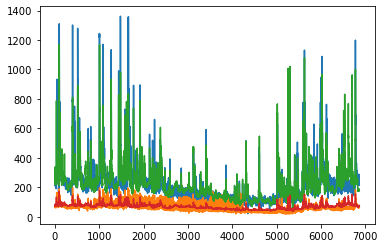

In [29]:
plt.plot(iop_linear_w_temp[0]['Y_train'])
plt.plot(iop_linear_w_temp[0]['Y_train_pred'])
# plt.yscale('log')

### Raingauge, temperature and OHE

In [30]:
config_linear_w_temp_and_ohe = {
    'name': 'Linear model w temp and pattern',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : lag
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp_and_ohe)

def linear_model():
    return LinearRegression()

(history_linear_w_temp_and_ohe,models_linear_w_temp_and_ohe,iop_linear_w_temp_and_ohe) =\
        evaluate_model(model_constructor=linear_model,
                       input_data=np.c_[Xg_all_seq,Xt_all_seq,hour_ohe_single],
                       output_data = Y_all_single,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False)



## Neural network models


### Common components

In [31]:
district_heating = {
    'n_rolling_temperature':24,
    'dense_1': 5,
    'dense_2': 2,
    'activation_1': 'relu',
    'activation_2': 'relu',
     }

pattern = {
    'pattern_length': 24,
    'pattern_constraint':'nonneg',
}
   
optimizer_params = {
    'name': 'Adam',
    'learning_rate': 0.001,
    'decay': 0.0,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-07,
    'amsgrad': False
    }

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]

### Simple recurrent model

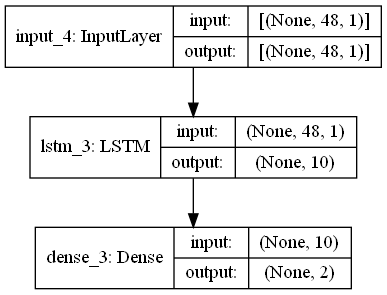

In [32]:
config_recurrent_simple = {
    'name': 'Simple recurrent model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    'lag': lag,
    # model

    'rainfall_runoff': {
        'lag': 48,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24*3,
    'epochs': 60,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project=project, config=config_recurrent_simple)


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)


def simple_recurrent_model():
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'], 1)),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(simple_recurrent_model(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [33]:
# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_recurr_simple,models_recurr_simple,iop_recurr_simple) =\
         evaluate_model(model_constructor=simple_recurrent_model,
                        input_data=Xg_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis],
                        output_data = Y_all_single,
                        thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=False,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                            ],
                          verbose=1
                          )


Epoch 1/60
96/96 [==============================] - 7s 28ms/step - loss: 24032.3340 - mean_absolute_error: 99.5657 - mean_squared_error: 24032.3340 - correlation: 0.2010 - val_loss: 11605.3750 - val_mean_absolute_error: 56.4410 - val_mean_squared_error: 11605.3750 - val_correlation: 0.1477
Epoch 2/60
96/96 [==============================] - 2s 16ms/step - loss: 13116.6475 - mean_absolute_error: 59.1660 - mean_squared_error: 13116.6475 - correlation: 0.1351 - val_loss: 7903.4526 - val_mean_absolute_error: 45.4313 - val_mean_squared_error: 7903.4526 - val_correlation: 0.0678
Epoch 3/60
96/96 [==============================] - 2s 17ms/step - loss: 10308.6279 - mean_absolute_error: 51.5746 - mean_squared_error: 10308.6279 - correlation: 0.1113 - val_loss: 7436.7939 - val_mean_absolute_error: 46.1931 - val_mean_squared_error: 7436.7939 - val_correlation: nan
Epoch 4/60
96/96 [==============================] - 2s 18ms/step - loss: 9716.9795 - mean_absolute_error: 50.7910 - mean_squared_error

### Recurrent with temperature

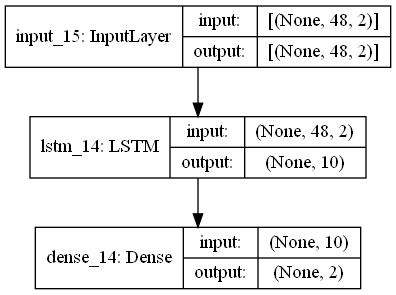

In [35]:
config_recurrent_simple_w_temp = {
    'name': 'Simple recurrent model with temperature',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model

    'rainfall_runoff': {
        'lag': 48,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24*3,
    'epochs': 60,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}
wandb.init(project=project, config=config_recurrent_simple_w_temp)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

def simple_recurrent_model_w_temp():
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],2)),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ],'rain_gauge')


    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model

Xg_tmp = Xg_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis]
Xt_tmp = Xt_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis]



tf.keras.utils.plot_model(simple_recurrent_model_w_temp(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [36]:

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_recurr_simple_w_temp,models_recurr_simple_w_temp,iop_recurr_simple_w_temp) =\
         evaluate_model(model_constructor=simple_recurrent_model_w_temp,
                        input_data=np.c_[Xg_tmp,Xt_tmp],
                        output_data = Y_all_single,
                        thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=False,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                            ],
                          verbose=1
                          )

Epoch 1/60
96/96 [==============================] - 3s 15ms/step - loss: 24556.5820 - mean_absolute_error: 101.3216 - mean_squared_error: 24556.5820 - correlation: -0.2140 - val_loss: 12345.7217 - val_mean_absolute_error: 59.3524 - val_mean_squared_error: 12345.7217 - val_correlation: 0.0703
Epoch 2/60
96/96 [==============================] - 1s 12ms/step - loss: 13933.4219 - mean_absolute_error: 61.7694 - mean_squared_error: 13933.4219 - correlation: -0.2158 - val_loss: 8260.7051 - val_mean_absolute_error: 45.8867 - val_mean_squared_error: 8260.7051 - val_correlation: 0.0432
Epoch 3/60
96/96 [==============================] - 1s 10ms/step - loss: 10697.7793 - mean_absolute_error: 52.4399 - mean_squared_error: 10697.7793 - correlation: -0.1952 - val_loss: 7465.9072 - val_mean_absolute_error: 45.5552 - val_mean_squared_error: 7465.9072 - val_correlation: nan
Epoch 4/60
96/96 [==============================] - 1s 10ms/step - loss: 9840.7861 - mean_absolute_error: 50.7468 - mean_squared_e

### Recurrent with temperature and pattern

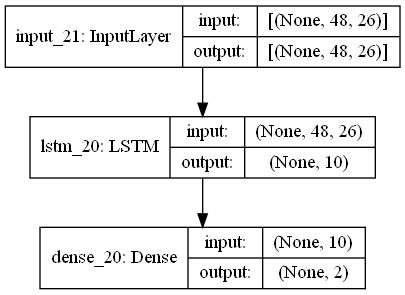

In [37]:
config_recurrent_simple_w_temp_and_pattern = {
    'name': 'Simple recurrent model with temperature and pattern',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model

    'rainfall_runoff': {
        'lag': 48,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24*3,
    'epochs': 60,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project=project, config=config_recurrent_simple_w_temp_and_pattern)


def simple_recurrent_model_w_temp_and_pattern():
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],2+24)),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ],'rain_gauge')


    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model

Xg_tmp = Xg_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis]
Xt_tmp = Xt_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis]
Xp_tmp = hour_ohe_seq[:,-wandb.config['rainfall_runoff']['lag']:]


tf.keras.utils.plot_model(simple_recurrent_model_w_temp_and_pattern(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [39]:

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_recurr_simple_w_temp_and_pattern,models_recurr_simple_w_temp_and_pattern,iop_recurr_simple_w_temp_and_pattern) =\
         evaluate_model(model_constructor=simple_recurrent_model_w_temp_and_pattern,
                        input_data=np.c_[Xg_tmp,Xt_tmp,Xp_tmp],
                        output_data = Y_all_single,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=False,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                            ],
                          verbose=1
                          )


Epoch 1/60
96/96 [==============================] - 8s 36ms/step - loss: 24978.0781 - mean_absolute_error: 103.2977 - mean_squared_error: 24978.0781 - correlation: nan - val_loss: 12490.6514 - val_mean_absolute_error: 59.7282 - val_mean_squared_error: 12490.6514 - val_correlation: 1.7454e-08
Epoch 2/60
96/96 [==============================] - 2s 25ms/step - loss: 14051.6602 - mean_absolute_error: 62.1446 - mean_squared_error: 14051.6602 - correlation: nan - val_loss: 8299.1719 - val_mean_absolute_error: 45.9456 - val_mean_squared_error: 8299.1719 - val_correlation: 3.6678e-08
Epoch 3/60
96/96 [==============================] - 2s 22ms/step - loss: 10733.6689 - mean_absolute_error: 52.5255 - mean_squared_error: 10733.6689 - correlation: nan - val_loss: 7470.3657 - val_mean_absolute_error: 45.5195 - val_mean_squared_error: 7470.3657 - val_correlation: nan
Epoch 4/60
96/96 [==============================] - 2s 22ms/step - loss: 9850.7490 - mean_absolute_error: 50.7516 - mean_squared_error

### Simple conceptual model

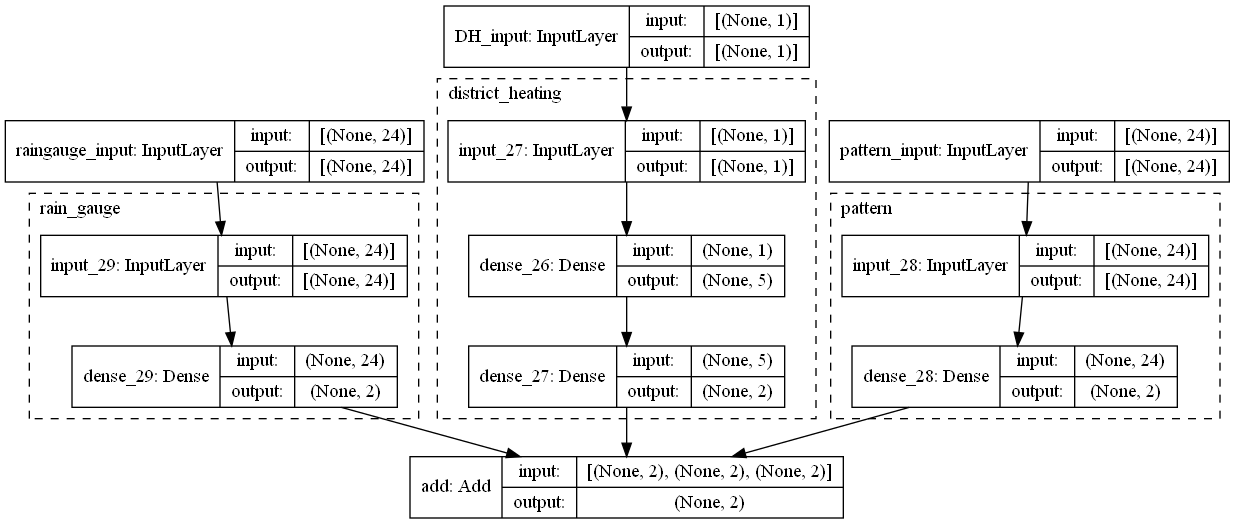

In [40]:
# subproject = 'conceptual_model'
config_conceptual_simple = {
    'name': 'Simple conceptual model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    
    'rainfall_runoff': {
        'lag': 24,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
}

wandb.init(project=project, config=config_conceptual_simple)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)


def conceptual_model_simple():
    # wandb.init(project=project, config=config_conceptual_simple)
    tf.random.set_seed(wandb.config['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  wandb.config['pattern']['pattern_constraint']))
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],)),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    District_heating_input = Input((1,), name='DH_input')
    Daily_pattern_input = Input(
        (wandb.config['pattern']['pattern_length'],), name='pattern_input')
    Rainfall_runoff_input = Input(
        (wandb.config['rainfall_runoff']['lag'],), name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [41]:
# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_con_simple, models_con_simple, iop_con_simple) =\
         evaluate_model(model_constructor=conceptual_model_simple,
                        input_data=[
                              Xt_all_single,
                              hour_ohe_single,
                              Xg_all_seq[:,-wandb.config['rainfall_runoff']['lag']:]],
                        output_data=Y_all_single,
                       thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)


Epoch 1/120
286/286 [==============================] - 2s 3ms/step - loss: 9550.9434 - mean_absolute_error: 52.9843 - mean_squared_error: 9550.9434 - correlation: 0.3765 - val_loss: 5146.7100 - val_mean_absolute_error: 33.5097 - val_mean_squared_error: 5146.7100 - val_correlation: 0.3041
Epoch 2/120
286/286 [==============================] - 1s 2ms/step - loss: 6449.1172 - mean_absolute_error: 40.5315 - mean_squared_error: 6449.1172 - correlation: 0.5031 - val_loss: 4439.0552 - val_mean_absolute_error: 35.6248 - val_mean_squared_error: 4439.0552 - val_correlation: 0.3350
Epoch 3/120
286/286 [==============================] - 1s 2ms/step - loss: 5811.0811 - mean_absolute_error: 38.9252 - mean_squared_error: 5811.0811 - correlation: 0.5116 - val_loss: 4068.1824 - val_mean_absolute_error: 33.9738 - val_mean_squared_error: 4068.1824 - val_correlation: 0.3526
Epoch 4/120
286/286 [==============================] - 1s 2ms/step - loss: 5414.2969 - mean_absolute_error: 37.9485 - mean_squared_er

In [43]:
# # with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
#     (history_recurr_simple,models_recurr_simple,iop_recurr_simple) =\
#          evaluate_model(model_constructor=simple_recurrent_model,
#                         input_data=Xg_all_seq[:,-wandb.config['rainfall_runoff']['lag']:,np.newaxis],
#                         output_data = Y_all_single,
#                        thresholds = thresholds,
#                         fn_crossval=wandb.config['cross_validation']['fn_kfold'],
#                         folds=wandb.config['cross_validation']['folds'],
#                         tensorflow_model=True,
#                         multiple_inputs=False,
#                         # Kwargs
#                         batch_size=wandb.config['batch_size'],
#                         epochs=wandb.config['epochs'],
#                         shuffle=True,
#                         callbacks=[
#                             lr_scheduler,
#                             early_stopper,
#                             # logging_callback
#                             ],
#                           verbose=1
#                           )


### Conceptual model with recurrent rainfall runoff

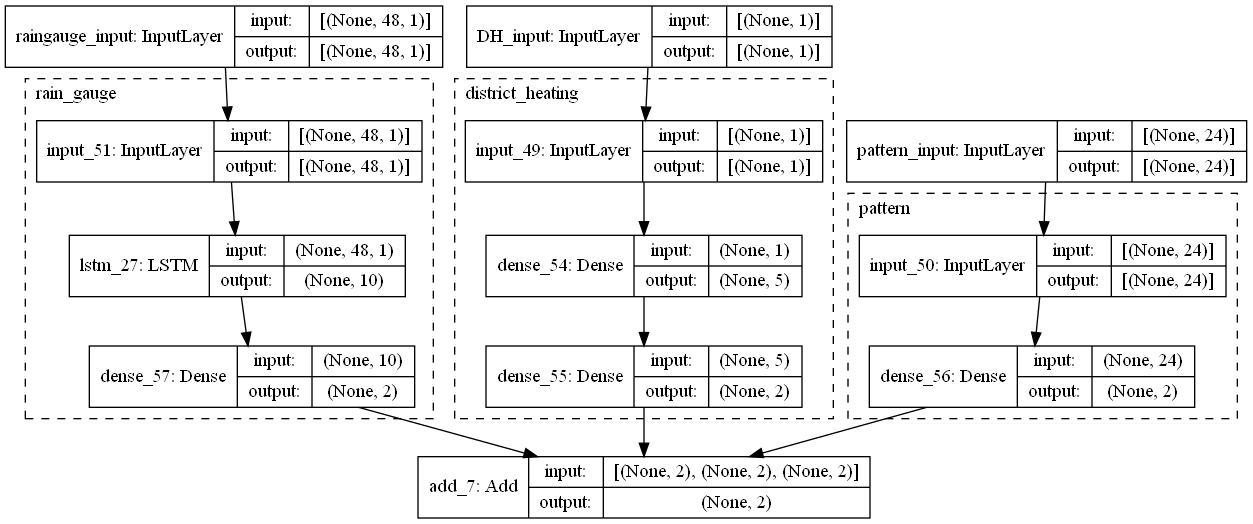

In [45]:

config_conceptual_recurrent = {
    'name': 'Conceptual model with recurrent rainfall-runoff',
    
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'lag' : lag,

    'rainfall_runoff': {
        'lag': lag,
        'lstm': 10,
        'dense_1': 2,
        'activation_1': 'relu'
    },
    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}
wandb.init(project=project, config=config_conceptual_recurrent)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def conceptual_model_recurrent():

    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  wandb.config['pattern']['pattern_constraint']
              ))], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],1)),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ], 'rain_gauge')

    District_heating_input = Input((1,), name='DH_input')
    Daily_pattern_input = Input(
        (wandb.config['pattern']['pattern_length'],), name='pattern_input')
    Rainfall_runoff_input = Input(
        (wandb.config['rainfall_runoff']['lag'], 1), name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model

tf.keras.utils.plot_model(conceptual_model_recurrent(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [46]:
Xg_tmp = Xg_all_seq[:, -wandb.config['rainfall_runoff']['lag']:, np.newaxis]
Xt_tmp = Xt_all_seq[:, -wandb.config['rainfall_runoff']['lag']:, np.newaxis]


# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_dict_conceptual_recurrent,
     models_conceptual_recurrent, iop_conceptual_recurrent) =\
        evaluate_model(model_constructor=conceptual_model_recurrent,
                       input_data=[
                           Xt_all_single,
                           hour_ohe_single,
                           Xg_tmp  # np.c_[Xg_tmp,Xt_tmp]
                       ],
                       output_data=Y_all_single,
                       thresholds=thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=True,
                       multiple_inputs=True,
                       # Kwargs
                       batch_size=wandb.config['batch_size'],
                       epochs=wandb.config['epochs'],
                       shuffle=True,
                       callbacks=[
                           lr_scheduler,
                           early_stopper,
                           # logging_callback
                       ],
                       verbose=1)


Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
286/286 [==============================] - 5s 10ms/step - loss: 12388.8086 - mean_absolute_error: 61.4974 - mean_squared_error: 12388.8086 - correlation: -0.0983 - val_loss: 7189.5098 - val_mean_absolute_error: 44.4757 - val_mean_squared_error: 7189.5098 - val_correlation: 0.2317
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
286/286 [==============================] - 3s 9ms/step - loss: 8932.6025 - mean_absolute_error: 48.6459 - mean_squared_error: 8932.6025 - correlation: 0.2505 - val_loss: 6908.1328 - val_mean_absolute_error: 47.0662 - val_mean_squared_error: 6908.1328 - val_correlation: 0.1945
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.09435121013771039.
286/286 [==============================] - 3s 9ms/step - loss: 8697.7852 - mean_absolute_error: 47.6370 - mean_squared_error: 8697.7852 - correlation: 0.2522 - val_loss: 6795.8677 - val_mean_a

In [77]:
plt.plot(history_dict_conceptual_recurrent[4]['Y_val'])
plt.plot(history_dict_conceptual_recurrent[4]['Y_val_pred'])
plt.plot(history_dict_conceptual_simple[4]['Y_val_pred'])
plt.legend(['True','Recurrent model prediction', 'Linear model prediction'])

KeyError: 'Y_val'

(1500.0, 2000.0)

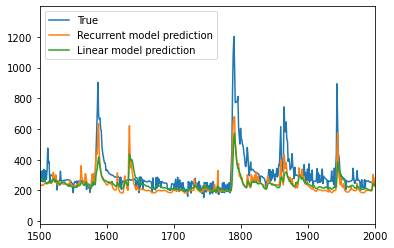

In [ ]:
plt.plot(history_dict_conceptual_recurrent[4]['Y_val'])
plt.plot(history_dict_conceptual_recurrent[4]['Y_val_pred'])
plt.plot(history_dict_conceptual_simple[4]['Y_val_pred'])
plt.legend(['True','Recurrent model prediction', 'Linear model prediction'])
plt.xlim(1500,2000)

(3200.0, 3600.0)

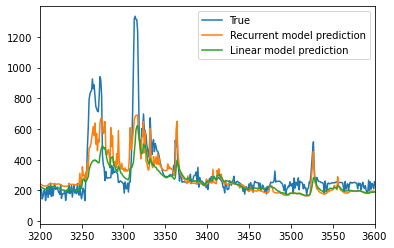

In [ ]:
plt.plot(history_dict_conceptual_recurrent[4]['Y_val'])
plt.plot(history_dict_conceptual_recurrent[4]['Y_val_pred'])
plt.plot(history_dict_conceptual_simple[4]['Y_val_pred'])
plt.legend(['True','Recurrent model prediction', 'Linear model prediction'])
plt.xlim(3200,3600)

(5950.0, 6300.0)

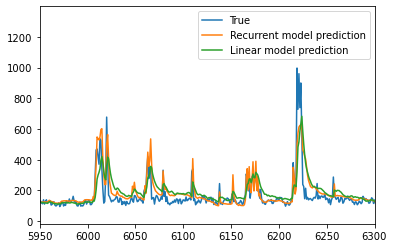

In [ ]:
plt.plot(history_dict_conceptual_recurrent[4]['Y_val'])
plt.plot(history_dict_conceptual_recurrent[4]['Y_val_pred'])
plt.plot(history_dict_conceptual_simple[4]['Y_val_pred'])
plt.legend(['True','Recurrent model prediction', 'Linear model prediction'])
plt.xlim(5950,6300)

In [ ]:
[i.name for i in models_conceptual_recurrent[-1].layers]

['raingauge_input',
 'DH_input',
 'pattern_input',
 'rain_gauge',
 'district_heating',
 'pattern',
 'add_64']

In [ ]:
[i.name for i in models_con_simple[-1].layers]

['raingauge_input',
 'DH_input',
 'pattern_input',
 'rain_gauge',
 'district_heating',
 'pattern',
 'add_70']

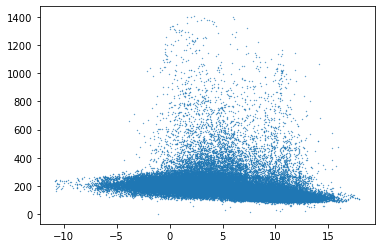

In [ ]:
from scipy.stats import binned_statistic
output = binned_statistic(Xt_all_seq,Y_all_seq,)

In [ ]:
bin_centers = (output.bin_edges[:-1] + output.bin_edges[1:])/2
bin_means = output.statistic

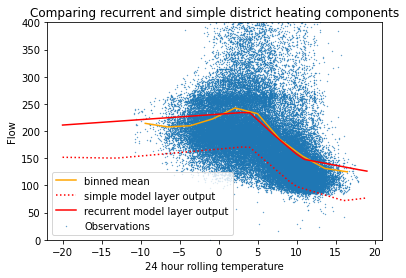

In [ ]:
x_tmp = np.arange(-20,20).reshape(-1,1)
plt.scatter(Xt_all_seq,Y_all_seq,s=0.1)
plt.plot(bin_centers,bin_means,color='orange')
plt.plot(x_tmp,models_con_simple[-1].layers[-3](x_tmp),c='r',linestyle ='dotted')
plt.plot(x_tmp,models_conceptual_recurrent[-1].layers[-3](x_tmp),c='r')
plt.ylim(0,400)
plt.ylabel('Flow')
plt.xlabel('24 hour rolling temperature')
plt.title('Comparing recurrent and simple district heating components')
plt.legend(['binned mean','simple model layer output','recurrent model layer output','Observations',])

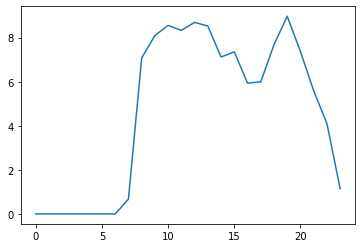

In [ ]:
plt.plot(models_conceptual_simple[-1].weights[-1].numpy())

In [ ]:
[(i.name,i.shape) for i in models_conceptual_recurrent[0].weights]

[('lstm_7/lstm_cell_7/kernel:0', TensorShape([1, 40])),
 ('lstm_7/lstm_cell_7/recurrent_kernel:0', TensorShape([10, 40])),
 ('lstm_7/lstm_cell_7/bias:0', TensorShape([40])),
 ('dense_65/kernel:0', TensorShape([10, 1])),
 ('dense_65/bias:0', TensorShape([1])),
 ('dense_62/kernel:0', TensorShape([1, 5])),
 ('dense_62/bias:0', TensorShape([5])),
 ('dense_63/kernel:0', TensorShape([5, 1])),
 ('dense_63/bias:0', TensorShape([1])),
 ('dense_64/kernel:0', TensorShape([24, 1]))]

(1500.0, 2000.0)

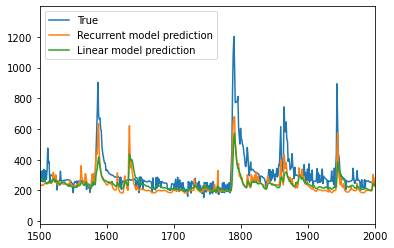

In [ ]:
plt.plot(history_dict_conceptual_recurrent[4]['Y_val'])
plt.plot(history_dict_conceptual_recurrent[4]['Y_val_pred'])
plt.plot(history_dict_conceptual_simple[4]['Y_val_pred'])
plt.legend(['True','Recurrent model prediction', 'Linear model prediction'])
plt.xlim(1500,2000)

<AxesSubplot:xlabel='CTime'>

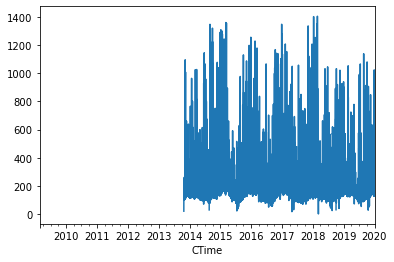

In [ ]:
Y_all.loc[:,'RVK-GEL'].plot()

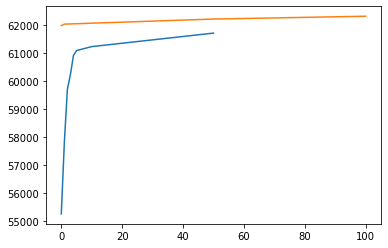

In [ ]:
# with good_value filtering done after cropping
# 61974 with no interpolation
# 62028 by allowing 1 missing
# 62209 by allowing 50 missing
# 62309 by allowing 100 missing

# 55265 with no interpolation and before changing the filtering to after taking last value
# 57807 by allowing 1 missing
# 59701 by allowing 2 missing
# 60234 by allowing 3 missing
# 60912 by allowing 4 missing
# 61085 by allowing 5 missing
# 61227 by allowing 10 missing
# 61708 bu allowing 50
# 62370 by allowing all missing

# nothing: 41008 missing rows
# allow 1 missing : 43786 (44234 But also now replaced missing values from Xg with the raw values)
# allow 2 missing : 44327 (44779 with change above)
# allow 5 missing : 45092 (45546 with above change)
# allow 12 missing : (4671 with above change)
# allow all missing : 49095 (49549)

plt.plot([0, 1, 2, 3, 4, 5, 10, 50],
         [55265, 57807, 59701, 60234, 60912, 61085, 61227, 61708])

plt.plot([0, 1, 50, 100],
         [61974, 62028, 62209, 62309])




In [ ]:
# df_table = pd.DataFrame(history_linear).T.applymap(float)
# table = wandb.Table(data=df_table,columns=df_table.columns.values)
# wandb.log({'table2':table})

# line_plot = wandb.plot.line(table, x='fold', y='val_mean_squared_error', title='Line Plot')
# histogram = wandb.plot.histogram(table, value='val_mean_squared_error', title='Histogram')
# scatter = wandb.plot.scatter(table, x='fold', y='val_mean_squared_error', title='Scatter Plot')

# wandb.log({'line_1': line_plot, 
#             'histogram_1': histogram, 
#             'scatter_1': scatter})
